In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import numpy as np
import pandas as pd
file_path  = '/content/drive/MyDrive/Deep Learning/APE'
os.chdir(file_path)

import re

In [2]:
# Import all our usual data from the ape module created.
from ape import *
#from tensorflow.keras.callbacks import EarlyStopping as ES
import matplotlib.pyplot as plt
import unicodedata

In [ ]:
!pip install tensorflow_text
import tensorflow_text as tf_text

In [4]:
#!unzip de-en_train_dev.zip

In [5]:
data_dir = os.path.abspath('de-en_train_dev')
data_dir

'/content/drive/MyDrive/Deep Learning/APE/de-en_train_dev'

## Preprocessing data

We load the data from storage and preprocess data exactly as we did with the English/Spanish dataset.

In [6]:
# We extract all the sentences from the data file appropriately
train_files = ['de-en.train.src',
               'de-en.train.mt',
               'de-en.train.pe']

dev_files = ['de-en.dev.src',
             'de-en.dev.mt',
             'de-en.dev.pe']
# Create list to save all the datasets appropriately:
train_source = [] # training data for source sentences
train_target = [] # training data for machine translated sentences
train_pe = [] # training data for human post edited sentences
dev_source = [] # development data for source sentences.
dev_target =[] # development data for machine translated sentences
dev_pe = [] # development data for human post edited sentences.

# Go through both training file and development file:
for train, dev in zip(train_files, dev_files):
  # get training path
  train_path = os.path.join(data_dir, train)
  # get path to development file
  dev_path = os.path.join(data_dir, dev)

  # open file and append them to the appropriate list:
  with open(train_path, 'rb') as f:
    # If path ends with source append to train_source list:
    if train_path.endswith('src'):
      train_source.extend(f.readlines())
    # If path ends with target, append to train_target list:
    elif train_path.endswith('mt'):
      train_target.extend(f.readlines())
    # Else append to train_pe list:
    else:
      train_pe.extend(f.readlines())
  # Do as above for development dataset:
  with open(dev_path, 'rb') as f:
    if dev_path.endswith('src'):
      dev_source.extend(f.readlines())
    elif dev_path.endswith('mt'):
      dev_target.extend(f.readlines())
    else:
      dev_pe.extend(f.readlines())

print('Source: ',train_source[-1])
print('MT output: ',train_target[-1])
print('Human pe: ', train_pe[-1])

print()
print('Source: ',dev_source[-1])
print('MT output: ',dev_target[-1])
print('Human pe: ', dev_pe[-1])

Source:  b'89 \xe2\x80\xa2 Z\xc3\xa4hneknirschen , Fl\xc3\xbcssigkeitsverlust , Hitze- oder K\xc3\xa4ltegef\xc3\xbchl , Durst , Engegef\xc3\xbchl im Hals , oder Nasenbluten . \xe2\x80\xa2 Erh\xc3\xb6hter Cholesterinspiegel im Blut .\n'
MT output:  b'89 \xe2\x80\xa2 \xe2\x80\xa2 Digestive disorders Very common : nausea , dehydration , unconsciousness , feeling cold or uncomfortable upper respiratory tract congestion , thirst , throat tightness , nose bleed , blood . \xe2\x80\xa2 Increased level of cholesterol in the blood .\n'
Human pe:  b'89 \xe2\x80\xa2 Bruxism , dehydration , feeling heat or cold , thirst , throat tightness , nose bleed . \xe2\x80\xa2 Increased level of cholesterol in the blood .\n'

Source:  b'Welche Ma\xc3\x9fnahmen werden zur Gew\xc3\xa4hrleistung der sicheren Anwendung von Thalidomide Celgene ergriffen ?\n'
MT output:  b'Which measures are being taken to ensure the safe use of Thalidomide Celgene ?\n'
Human pe:  b'Which measures are being taken to ensure the safe

In [7]:
print('Number of sentences in train_data: ',len(train_source))
print('Number of sentences in dev_data: ', len(dev_source))

Number of sentences in train_data:  25000
Number of sentences in dev_data:  1000


In [8]:
# Define max vocab size. We use a maximum vocabulary size of 15000

max_vocab_size = 18000

def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Remove next line escape characters.
  text = tf.strings.regex_replace(text, '\\n','')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # Add start and end token to each sentence:
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text



# Define src sentence preprocessor:
# This class helps to preprocess all sentences in the dataset by 
# first, cleaning with the tf_lower_and_split_punct function
# it tokenizes each word in the sentences to a unique integer value then 
# it creates a dictionary that maps the tokenized word to an integer.
# It also pads the sequence of words for each sentence to the same length.
# Later, it can vectorize any sentence input given to it to a vector of indexes representing each word in the each sentence.
src_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Define mt and hpe sentence preprocessor just as above:
mt_hpe_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Fit preprocessors to their respective dataset
src_text_processor.adapt(train_source)
mt_hpe_text_processor.adapt(train_target + train_pe)

## MOdel Training
We begin by initializing the APE model, spliting training data into train and test set. We then put this data into tf.data.Dataset object for easy fetching of data during trianing.

In [9]:
embedding_dim = 512
hidden = 1024
att_units = 256
linear_units = 512


ape = APE(hidden,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2)

# Configure the loss and optimizer
ape.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [10]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


train_source, train_target, train_pe = shuffle(train_source, train_target, train_pe, random_state=27)

train_src, train_mt, train_hpe = train_source[:21000], train_target[:21000], train_pe[:21000]
test_src, test_mt, test_hpe = train_source[21000:], train_target[21000:], train_pe[21000:]


#
#dev_source, dev_target, dev_pe = dev_source[1:], dev_target[1:], dev_pe[1:]

In [11]:
epochs = 25
TRAIN_BUFFER_SIZE = len(train_src)
BATCH_SIZE = 64
TEST_BUFFER_SIZE = len(test_src)

# This Dataset class shuffles the data and precreates batches for it.
dataset = tf.data.Dataset.from_tensor_slices((train_src, train_mt, train_hpe)).shuffle(TRAIN_BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



In [12]:
# Initialize the learning rate for the model.
initial_learning_rate = 0.001
# We schedule a learning rate for every epoch using the formula below:
# For every epoch, learning rate is reduced using this formula.
decay = initial_learning_rate / epochs

# We use a time based decay to schedule the learning rate which will be appropriate for online learning.
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)


# Now, create a checkpoint manager that saves the model and its parameters during training to file.
# This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/German_batch_Training"
ckpt = tf.train.Checkpoint(ape)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  # If you retrain this model then uncomment the next line of code:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  #start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)
#ckpt.restore(ckpt_manager.checkpoints[0])

In [13]:
np.log(mt_hpe_text_processor.vocabulary_size())

9.798127036878302

NOw, we train our baseline model.

In [14]:
# ape.fit(dataset,epochs=epochs,
#         callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],)

In [ ]:
# Checkpoint model
#ckpt_manager.save()

In [13]:

# This method creates a translator object.
def get_translator(model):
  return APETranslator(model.encoder, model.decoder, model.src_processor,model.mt_hpe_processor)


# translator = get_translator(ape)

In [14]:
# These methods preprocess sentencss by normalizing the characters of the string:
# It normalizes each character by removing any accents and representing the character with the closest ASCII character.

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', s.decode('utf-8'))
                   if unicodedata.category(c) != 'Mn')

def preprocess(sent):
  sentences = []
  for w in sent:
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/
    # python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([.?!,¿])", r" \1 ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r'[^ a-z.?!,¿]+', r"", w)
    w = re.sub(r'\\n', r'',w)
    w = w.rstrip().strip()
    sentences.append(w)
  return sentences


NOw, run this model on the test set and save the results into a csv file in storage for further evaluation.

In [ ]:

# Store test predictions here:
# predictions = []
# size = 500
# for i in range(0,len(test_src),size):
#   pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
#   predictions.extend(pred)
#   size += 500

# predictions = preprocess(predictions)
# df = pd.DataFrame({'Source': preprocess(test_src), 'Machine Translation ouput': preprocess(test_mt),
#                    'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})


# df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Ger_Eng_Result.csv')
# df.head()

## Training Development set in Batch and Online Learning Mode
First , we update the parameters of the development set in the batch mode. Then, we make a copy of the pretrained model and update in the online mode.


### Batch Learning Mode.
We load the model into memory and train on 1000 develpment samples. We use this because thats what was used for the online training below. Model was trained for 9 epochs. We also use a time-based learning rate schedule to prevent the model from overfitting on the development set.



In [ ]:
# Wrap development set data around tf.Data.Dataset object:
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_source, dev_target, dev_pe)).shuffle(TEST_BUFFER_SIZE)
dev_dataset = dev_dataset.batch(BATCH_SIZE)
dev_dataset = dev_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#ape.fit(dev_dataset,epochs=12, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],)

In [ ]:

# translator = get_translator(ape)

# predictions = []
# size = 500
# for i in range(0,len(test_src),size):
#   pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
#   predictions.extend(pred)
#   size += 500

# predictions = preprocess(predictions)


In [ ]:
# df = pd.DataFrame({'Source': preprocess(test_src), 'Machine Translation ouput': preprocess(test_mt),
#                    'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})


# df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_update_APE_Ger_Eng_Result.csv')
# df.head()

### Online training Mode
We also train another model loaded from the last baseline model checkpoint in online mode. We follow all the steps as described in the English/Spanish notebook.
It consists of 2 steps: 
- An instance selection method and trainng: Similar datapoints are selected from the knowledge base of data and used to update the model's parameters. The epochs range from 3 to 8 depending on how similar these datapoints are to the query datapoint (3 if similarity is low and 8 when similarity score is high). A learning scheduler was used.

- Datapoint training: At every iteration, the model is eventually trained on each datapoint after the first step as above. To reduce possible overfitting here ,the number of epoch was reduced to 3 and the learning rate was given by:

        learning_rate = learning_rate/ (1 + epoch_number)

First, let's initialize our vectorizer, prepare our data into tuples, then train the model.

Initially, we load our model from the last baseline model's checkpoint. However, to save time and prevent repitition during online training, we create a checkpoint callback that saves the model parameters in a new file after a certain number of batches. We do this so training can be continued directly from the last datapoint seen previously everytime we rerun the online training method.

In [15]:
# First we import the stop words list for english from the nltk library.
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# Initialize vectorizer:
vectorizer = Vectorizer(encoding='ascii',ngram_range=(1,2),decode_error='ignore',stop_words=stop_words,max_df=0.7,max_features=3000)


In [17]:
# preprocess the dataset and convert to an array of sentences:
source = np.array(preprocess(train_source))

In [20]:
# Now fit the vectorizer to the preprocessed data:
vectorizer.fit(source)


TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='ascii',
                input='content', lowercase=True, max_df=0.7, max_features=3000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [21]:
# use a certain amount of data in the development set:
n_samples = 1000
# define knowledge base by packing dataset into a tuple:
data = [train_source, train_target, train_pe]
# define development stream dataset by packing dataset into a tuple:
#sent_stream = (dev_source[1:151],dev_target[1:151],dev_pe[1:151])
sent_stream = [dev_source[:n_samples],dev_target[:n_samples],dev_pe[:n_samples]]

sent_st = [dev_source[:n_samples], dev_target[:n_samples]] 

We first initialize model using the last checkpointed baseline model's parameters. Hence the code commented out. Subsequently, we make use of a callback to save every updated model parameters during online training. Only the parameters with the best perfomance (batch loss) are saved to storage at any given time.

In [22]:
ape_model = APE(hidden,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2)
# Configure the loss and optimizer
ape_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)



# # Now, create a checkpoint manager that saves the model and its parameters during training to file.
# # This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/German_Batch_Training"
ckpt = tf.train.Checkpoint(ape_model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  # If you retrain this model then uncomment the next line of code:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  #start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

  #restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


Define model checkpoint callback

In [23]:
# This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Ger_Eng_online_train"

# Load weights from last checkpoint from online training.

#ape_model.load_weights(checkpoint_path)

cp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='batch_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq=5
)

In [26]:
# Initialize the learning rate for the model.
initial_learning_rate = 0.001
# We schedule a learning rate for every epoch using the formula below:
# For every epoch, learning rate is reduced using this formula.
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

def get_datastr(src, mt, hpe, batch_size=64):
  buffer_size = len(src)
  BATCH_SIZE = batch_size

  # This Dataset class shuffles the data and precreates batches for it.
  dataset = tf.data.Dataset.from_tensor_slices((src, mt, hpe)).shuffle(buffer_size)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def online_ape( sent_stream, ape_model, vectorizer,ckpt_cb,data=None,start_point=0,
               epochs= 3,threshold=0.35,initial_learning_rate=0.001, interactive=False):
  '''
    This function is implemented from Matteo Negri et al (2017) as explained above.
    Args:
    sent_stream: development dataset for online training (i.e src, mt ,hpe)
    ape_model: new or pretrained ape model. If new model, data cannot be empty.
    ckpt_manager: checkpoint manager.
    vectorizer: vectorizer object that vectorizes sentences.
    data: knowledge base (kb) that stores all the processed/learned sent_stream sets and/or ape training data in format (src, mt , hpe).
    epochs: Number of iterations to train the model on data.
    threshold: similarity score threshold to use when retrieving similar datapoints.
    interactive: Used to interact directly with any user who chooses to provide the right human post edit for every src, mt pair.
  '''
   # initialize some variables
  if start_point == 0:
    trained_samples = start_point
  else:
    trained_samples = start_point - 1


  # Unpack
  if not interactive:
    src, mt, hpe = sent_stream
    src, mt , hpe = src[start_point:], mt[start_point:], hpe[start_point:]

    # Reverse list for popping:
    src.reverse()
    mt.reverse()
    hpe.reverse()
  else:
    src, mt = sent_stream
    # Reverse list for popping:
    src.reverse()
    mt.reverse()

  # while sentence still remains in the stream, pop one sentence from the stream:
  while(len(src) != 0):
    # Get one sentence at a time:
    src_sent = [src.pop()] 
    mt_sent = [mt.pop()] 
    # Retrieve sentences similar to this sentence from the dataset:
    # If no dataset (knowldedge base):
    if not data:
      # Make copy of generic model and predict translation:
      #model = deepcopy(ape_model)
      # Create the translator version of this generic model:
      editor = get_post_editor(ape_model)
      
    else:
      # Vectorize source sentence:
      sentence = vectorizer.transform(src_sent)
      # Calculate the similarity between sentence and dataset source sentences:
      similarity_score = cosine_similarity(sentence, vectorizer.transform(np.array(data[0])))
      # sort similarity scores with respective index and convert to an np array:
      similarity_score = np.array(sort_score(similarity_score))
      # Get relevant index of sentences above threshold value:
      relevant_index = similarity_score[similarity_score[:,1] >= threshold]

      # Get the relevant samples from the data using the index:
      relevant_src = np.array(data[0])[relevant_index[:,0].astype('int32')]
      relevant_mt = np.array(data[1])[relevant_index[:,0].astype('int32')]
      # ind = relevant_index[:,0].astype('int32')
      # print('Indexes', ind)
      # for i in range(len(ind)):
      #   print(np.array(data[2])[i])
      #print(np.array(data[2])[relevant_index[:,0].astype('int32')])
      relevant_hpe = np.array(data[2])[relevant_index[:,0].astype('int32')]

      #relevant_src[0].split())

      if relevant_src.shape[0] >= 3:
        #print('Sample size: ', relevant_src.shape[0])
        # Dynamically get number of epochs and learning rate. Then compile model using the learning_rate:
        epochs = set_hyperparameters(similarity_score, threshold, initial_learning_rate)
        #ape_model = model_compile(ape_model,learning_rate)
        
        # Locally adapt similar sentences to model:
        print(f'Training on {relevant_src.shape[0]} similar sample sentences...')
        # Get dataset object:
        dataset = get_datastr(list(relevant_src), list(relevant_mt), list(relevant_hpe))
        #return dataset
        #Train model:
        ape_model.fit(dataset,epochs=epochs,
                      callbacks=[LearningRateScheduler(lr_time_based_decay),ckpt_cb])

      # Get translator version of the trained model:
      editor  = get_post_editor(ape_model)

    # If dataset is empty, create the right structure for it:
    if not data:
      data = [[],[],[]]

    if interactive :
      # Predict translation of the sentence:
      pe = editor.single_post_edit(src_sent,mt_sent)
      #pe = pe.encode('utf-8')
      #predictions.append(pe)
      hpe_sent , train = get_human_post_edit(src_sent[0], pe)
    else:
      train = True
      hpe_sent = [hpe.pop()]

    # Update model according to new sentence if train is set to True
    if train:
      # Get dataset object:
      dataset = get_datastream(src_sent,mt_sent,hpe_sent, batch_size=1)
      # Train model:
      ape_model.fit(dataset, epochs=epochs, callbacks=[LearningRateScheduler(lr_time_based_decay2),ckpt_cb])
    # Append the result to the dataset knowledge base (data):
    data[0].extend(src_sent)
    data[1].extend(mt_sent)
    if hpe_sent[0] == '':
      data[2].extend([pe])
    else:
      data[2].extend(hpe_sent)
    

    trained_samples += 1
    if trained_samples % 20 == 0:
      print(f'Samples trained: {trained_samples}')
    

  return  trained_samples
  

Now, we train it using the online mode. A slight edit was made for this particular online training. I decided to increase the batch size (from 5 to 64) for the instance selection model update to see if it leads to any significant change in performance.

In [27]:
trained_samples = online_ape(sent_stream, ape_model, vectorizer, cp,data = data,start_point= 10, interactive=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 501ms/step - batch_loss: 6.9417
Training on 5 similar sample sentences...
Epoch 1/3
1/1 [==============================] - 1s 1s/step - batch_loss: 4.8420
Epoch 2/3
1/1 [==============================] - 1s 1s/step - batch_loss: 4.8420
Epoch 3/3
1/1 [==============================] - 1s 1s/step - batch_loss: 4.8420
Epoch 1/3
1/1 [==============================] - 1s 1s/step - batch_loss: 8.4333
Epoch 2/3
1/1 [==============================] - 1s 1s/step - batch_loss: 8.4333
Epoch 3/3
1/1 [==============================] - 1s 1s/step - batch_loss: 8.4333
Training on 35 similar sample sentences...
Epoch 1/5
1/1 [==============================] - 1s 747ms/step - batch_loss: 5.4576
Epoch 2/5
1/1 [==============================] - 1s 766ms/step - batch_loss: 5.4576
Epoch 3/5
1/1 [==============================] - 1s 787ms/step - batch_loss: 5.4576
Epoch 4/5
1/1 [==============================] - 1s 

In [46]:
# loss = 
translator = get_translator(ape_model)

# Store test predictions here:
predictions = []
size = 500
for i in range(0,len(test_src),size):
  pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
  predictions.extend(pred)
  size += 500

predictions = preprocess(predictions)
df = pd.DataFrame({'Source': preprocess(test_src), 'Machine Translation ouput': preprocess(test_mt),
                   'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})


df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_online_APE_Ger_Eng_Result.csv')
df.head()

,Source,Machine Translation ouput,Machine Post Edit (APE),Human Post-Edit (HPE)
0,norvir enthalt den farbstoff gelborange s e ...,norvir contains the agent sunset yellow fcf e...,the fill rapamune . will ml website vial the...,norvir contains the agent sunset yellow fcf e...
1,daten aus einer begrenzten anzahl von schwange...,data from a limited number of exposed pregnanc...,with mg,data from a limited number of exposed pregnanc...
2,durch einstellung des blutzuckers werden die s...,"by controlling blood sugar , the symptoms an...",the who a rufinamide see olanzapin lactation e...,"by controlling blood sugar , the symptoms an..."
3,luminity wurde nicht speziell bei patienten mi...,luminity has not been specifically investigate...,a . valve,luminity has not been specifically investigate...
4,die in tabelle aufgefuhrten nebenwirkungen ba...,the adverse reactions listed in table is base...,the propyl . monitoring on the of for .,the adverse reactions listed in table are bas...


In [41]:

def ter_moving_average(y_true,y_pred,window_size=50):
  scores = TER_score(y_true, y_pred,False)
  scores = pd.Series(scores,index=range(1,len(scores)+1), name='TER').rolling(window= window_size).mean()
  #score['Moving Average'] = score['TER']
  return scores

def plot(scores,window_size=50):
  scores.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', xlabel= 'Samples',ylabel='TER average' )


def precision(improved, modified):
  return round(improved*100/modified ,2)


def TER_score(y_true, y_pred, reduce=True):
  # This function calculates the cummulative TER score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true = preprocess(y_true)
  scores = []
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    if type(mpe) != str:
      mpe = str(mpe)
    score = pyter.ter(mpe.split(),hpe.split())
    scores.append(score)
  if reduce:
    return round(np.array(scores).mean(),2)
  else:
    return np.array(scores)
    
def get_bleu_score(y_true, y_pred):
  # This function calculates the cummulative BLEU-4 score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true  = preprocess(y_true)
  scores = []
  #smooth_func = SmoothingFunction()
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    hpe = [hpe.split(' ')]
    if type(mpe) != str:
      mpe = str(mpe)
    mpe = mpe.split(' ')
    score = sentence_bleu(hpe,mpe)
    scores.append(score)
  


def get_bleu_score(y_true, y_pred):
  # This function calculates the cummulative BLEU-4 score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true  = preprocess(y_true)
  scores = []
  #smooth_func = SmoothingFunction()
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    mpe = str(mpe)
    hpe = [hpe.split(' ')]
    mpe = mpe.split(' ')
    score = sentence_bleu(hpe,mpe)
    scores.append(score)
  return round(np.array(scores).mean(),2)
    
    

  
def edits(hpe, mpe):
  word_to_index = {word: [] for word in mpe}
  #matched = {}
  hpe_len = len(hpe)
  mpe_len = len(mpe)
  count = 0
  matrix = np.zeros((hpe_len, mpe_len))
  for i, pred in enumerate(mpe):
    for j,true in enumerate(hpe):
      if pred == true:
        if j in word_to_index[pred] :
          continue
        else:
          matrix[j,i] = 1
          word_to_index[pred].append(j)
          count += 1
          
  insertions = np.sum(matrix, axis=1)
  deletions = np.sum(matrix, axis=0)
  matched = len(insertions[insertions > 0])
  
  n_insertions = len(insertions[insertions == 0])
  n_deletions = len(deletions[deletions == 0])
  if (hpe_len == mpe_len) or (mpe_len > hpe_len):
    substitutions = hpe_len - matched
  else:
    substitutions = mpe_len - matched
  
  return n_insertions, n_deletions, substitutions
  
def get_macroindicators(y_true, mt , y_pred,verbose=False):
  mt_pred_scores = np.array(TER_score(mt, y_pred, False))
  hpe_mt_scores = np.array(TER_score(y_true, mt, False))
  hpe_pred_scores = np.array(TER_score(y_true, y_pred,False))
  #index = np.amt_pred_scores.shape[0]
  improved = hpe_pred_scores < hpe_mt_scores
  modified = mt_pred_scores != 0
  deteriorated = hpe_pred_scores > hpe_mt_scores
  if verbose:
    print(f"Number of modified sentences: {modified.sum()}")
    print(f"Number of improved sentences: {improved.sum()}")
    print(f"Number of deteriorated sentences: {deteriorated.sum()}")
  else:
    return modified.sum(),improved.sum(), deteriorated.sum()


def get_microindicators(mt , mpe):
  insertions = []
  deletions = []
  substitutions = []
  for y_true, y_pred in zip(mt, mpe):
    insert, delete, substitute = edits(y_true.split(), y_pred.split())
    insertions.append(insert)
    deletions.append(delete)
    substitutions.append(substitute)

  return round(np.mean(insertions)), round(np.mean(deletions)), round(np.mean(substitutions))
  
  
  # loss, bleu_score, ter, macroindicators,precision.

def analyze_performance(y_true, mt=None, y_pred=None,train_loss= 0, epochs= 10, is_mt = False):
  # calculate BLEU and TER score:
  # If just the original machine translation:
  features = {'train_loss': str(train_loss), 'epochs': str(epochs),'BLEU score': 'N/A', 'TER score': 'N/A', 'Modified sentences (%)': 'N/A',
              'Improved sentences (%)': 'N/A', 'Deteriorated sentences (%)': 'N/A', 'Mean insertions': 'N/A', 'Mean deletions': 'N/A', 'Mean substitutions': 'N/A', 'Precision': 'N/A'}
  if is_mt:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, mt,to_string=True)
  else:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, y_pred,to_string=True)
    mod, imp, det = get_macroindicators(y_true, mt, y_pred)
    insertions , deletions , substitutions = get_microindicators(mt,y_pred)
    features['Modified sentences (%)'], features['Improved sentences (%)'], features['Deteriorated sentences (%)'] = str(round(mod*100/len(y_true),2)), str(round(imp*100/len(y_pred),2)) , str(round(det*100/len(y_pred),2))
    features['Mean insertions'] , features['Mean deletions'], features['Mean substitutions'] = str(insertions), str(deletions), str(substitutions)
    features['Precision'] = str(precision(imp, mod))
  return features

  

Now, lets create a csv file that stores the performance analysis of the different models: raw mt output, baseline model, batch updated model and online updated model. We will consider the following metric feature:
- Training loss
- Epoch
- BLEU
- TER
- Macroindicators : modified, improved ,deteriorated
- Microindicators : insertions, deletions, substitutions

Note here that training time and shift (microindicator) were not considered. The training time was not considered because of the constant breaks during training of online models. It took a lot of hours to run the online model especially using the CPU. Let's load the test results from file for each of this models.

We will also plot the moving averages of each of the models.

In [20]:
baseline_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Ger_Eng_Result.csv')
batch_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_update_APE_Ger_Eng_Result.csv')
online_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_online_APE_Ger_Eng_Result.csv')

In [53]:
mt_output = preprocess(test_mt)
human_edit = preprocess(test_hpe)
baseline_edit = [ str(sent) for sent in baseline_df['Machine Post Edit (APE)']]
batch_edit = [ str(sent) for sent in batch_df['Machine Post Edit (APE)']]
online_edit = [ str(sent) for sent in online_df['Machine Post Edit (APE)']]


def clean(sentence_list):
  sentences = []
  for sent in sentence_list:
    sentences.append(sent[2:-1])
  return sentences

In [22]:
!pip install pyter3
import pyter

In [23]:
import pyter

In [54]:
baseline_edit = clean(baseline_edit)

In [39]:
raw_mt_output_metrics = analyze_performance(human_edit, mt_output,epochs=0, is_mt=True)


In [56]:

baseline_metrics = analyze_performance(human_edit, mt_output, baseline_edit,train_loss=0.26,epochs=25)



In [57]:
# batch_output = [str(sent) for sent in  batch_df['Machine Post Edit (APE)']]
batch_updated_metrics  = analyze_performance(human_edit, mt_output,batch_edit, train_loss= 0.21, epochs=9)

In [58]:

online_updated_metrics = analyze_performance(human_edit, mt_output, online_edit,train_loss= 8.79, epochs= 3)

In [59]:
df = pd.DataFrame([raw_mt_output_metrics,baseline_metrics,batch_updated_metrics,online_updated_metrics],
    index=['Raw MT output','Baseline APE', 'Batch Updated APE','Online Updated APE'])
df = df.transpose()
df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Ger_Eng_Result_Analysis.csv')

In [60]:
df

,Raw MT output,Baseline APE,Batch Updated APE,Online Updated APE
train_loss,0,0.26,0.21,8.79
epochs,0,25,9,3
BLEU score,0.79,0.38,0.42,0.16
TER score,0.16,0.49,0.6,1.17
Modified sentences (%),N/A,81.85,87.45,100.0
Improved sentences (%),N/A,1.62,0.95,0.2
Deteriorated sentences (%),N/A,77.45,84.18,99.65
Mean insertions,N/A,5,5,14
Mean deletions,N/A,7,9,12
Mean substitutions,N/A,3,4,8


## TER Moving Average Plot
First, the TER moving average is calculated and then plotted on the same graph for easy comparison.

In [63]:
window_size =50

baseline_average = ter_moving_average(human_edit, baseline_edit, window_size=window_size)
batch_average = ter_moving_average(human_edit, batch_edit, window_size=window_size)
online_average = ter_moving_average(human_edit, online_edit, window_size=window_size)


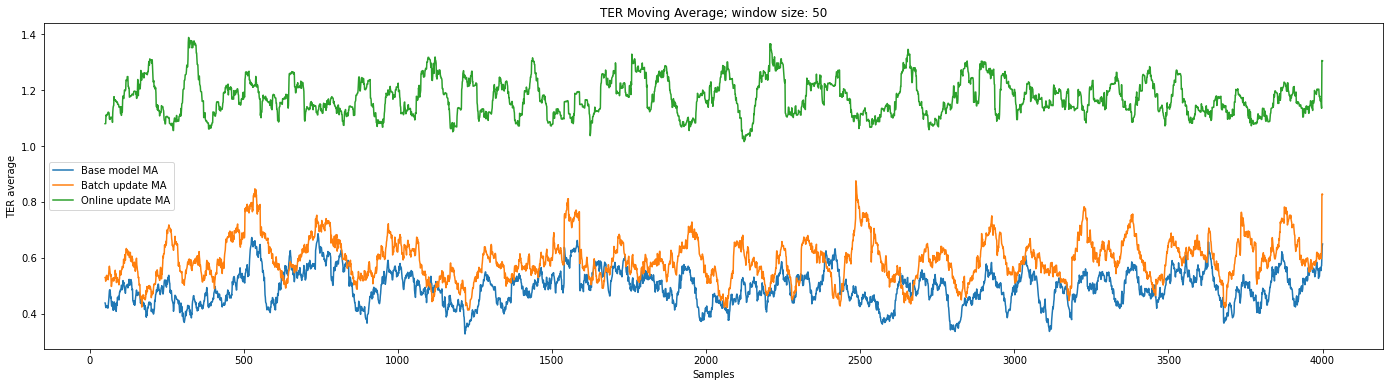

In [62]:
import matplotlib.pyplot as plt

baseline_average.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', label='Base model MA', xlabel= 'Samples',ylabel='TER average',legend=True )
batch_average.plot(label= 'Batch update MA', legend=True)
online_average.plot(label='Online update MA' ,legend=True)

## Conclusion
From the graph plot, the online model had the worst TER moving average in the long run which is clearly distinct from the 2 other models. The baseline model and batch update model seem to be competing though the baseline model seem to generally have a lower TER moving average signifying that it had a better generalization. It becomes possible that the batch updated model had overfitted a little to the development set. 

It must be known that a lot of factors were responsible for the differences in performance between this model and the research paper and some include:

- Different number of neurons,dropouts in the model's architecture: We used lesser here because of RAM space. For the dropouts, we followed a general scheme of 20% dropout.

- Different dataset: The model here was trained on about 10000 samples while that in the research was pretrained on 6.6M.

- Different environmental variables in the online training mode: threshold level for cosine similarity, number of epochs and learning rate for model update on instance selection datapoints, number of epochs and learning rate for model update on each development set datapoint.